In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets_snowstorm_iceprod_benchmark as datasets

# set the inputs
# reco_versions = ["snowstorm_iceprod_benchmark_level2", "snowstorm_iceprod_benchmark_level3casc","snowstorm_iceprod_benchmark_level3muon", "snowstorm_iceprod_benchmark_level8", "snowstorm_iceprod_benchmark_HESE","evtgen_v4_rec_v9"]
reco_versions = ["snowstorm_iceprod_benchmark_level2", "snowstorm_iceprod_benchmark_level3casc", "snowstorm_iceprod_benchmark_level8", "snowstorm_iceprod_benchmark_HESE","evtgen_v4_rec_v9"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/benchmark_snowstorm_iceprod/weighted_unweighted"
os.system(f"mkdir -p {plotting_path}")

0

In [7]:
# weight functions
AstroFluxModels = {
    "HESE": {
        "gamma_astro" : 2.87,
        "per_flavor_norm" : 2.12,
        "AstroFluxModel" : create_AstroFluxModel(per_flavor_norm=2.12, gamma_astro=2.87)
    },
    "cascade": {
        "gamma_astro" : 2.53,
        "per_flavor_norm" : 1.66,
        "AstroFluxModel" : create_AstroFluxModel(per_flavor_norm=1.66, gamma_astro=2.53)
    }
}

In [8]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    return simulation_dataset



In [9]:
keys_to_merge = {}

keys_to_merge["evtgen_v4_rec_v9"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["taureco_iceprod_benchmark_level8"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


keys_to_merge["snowstorm_iceprod_benchmark_level2"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_level3casc"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_level3muon"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_level8"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_HESE"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


In [10]:
for key in simulation_datasets: 
    print(20*"-", key)
    simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

-------------------- snowstorm_iceprod_benchmark_level2
----- Extracting files for NuTau_lowE


----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_lowE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_lowlowE
----- Extracting files for NuMu_lowE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_lowE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_lowlowE
Using NuMu_lowE
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_lowE
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
-------------------- snowstorm_iceprod_benchmark_level3casc
----- Extracting files for NuTau_lowE
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_lowE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_lowlowE
----- Extracting files for

In [11]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "HESE benchmark",
    "snowstorm_iceprod_benchmark_level2" : "level2",
    "snowstorm_iceprod_benchmark_level3casc" : "level3 cascade",
    "snowstorm_iceprod_benchmark_level3muon" : "level3 muon",
    "snowstorm_iceprod_benchmark_HESE" : "HESE",
    "snowstorm_iceprod_benchmark_level8" : "level8 cascade",
}

check if merging works now, seems to be fine

In [12]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        if "HESE" in key or "evtgen_v4_rec_v9" in key:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModels["HESE"]["AstroFluxModel"]) * livetime_s
        else:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModels["cascade"]["AstroFluxModel"]) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                       astro_NuE         astro_NuMu       astro_NuTau                      conv            prompt
level2          19925.14 ± 70.94  39683.13 ± 109.82  18797.96 ± 71.69  15437541.243 ± 42936.005  23646.06 ± 50.47
level3 cascade   3076.33 ± 34.22    1222.69 ± 23.40   2209.46 ± 29.53     143394.414 ± 2753.698   1871.18 ± 16.11
level8 cascade    273.47 ± 10.54      128.99 ± 8.56    290.80 ± 10.89        7499.498 ± 552.241     181.01 ± 5.03
HESE                40.16 ± 5.60       23.98 ± 4.27      26.41 ± 4.49           46.522 ± 11.687      10.80 ± 1.15
HESE benchmark      56.92 ± 0.55       20.60 ± 0.25      35.03 ± 0.40            41.078 ± 1.099      13.46 ± 0.10


In [14]:
def compare_dataset_flavor(
    dataset_key,
    var_key1="I3MCWeightDict",
    var_key2="PrimaryNeutrinoEnergy",
    variable_name="PrimaryNeutrinoEnergy [GeV]",
    bins=np.geomspace(1e4, 1e6, 20),
    xscale="log",
    savename="PrimaryNeutrinoEnergy",
    fluxmodelname = "HESE",
):
    # Bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    fig.suptitle(rf"Dataset {dataset_key}", fontsize=16)

    AstroFluxModel = AstroFluxModels[fluxmodelname]["AstroFluxModel"]
    per_flavor_norm = AstroFluxModels[fluxmodelname]["per_flavor_norm"]
    gamma_astro = AstroFluxModels[fluxmodelname]["gamma_astro"]

    # Loop over the two panels
    for ax, weighted in zip(axes, [False, True]):
        ax.set_xscale(xscale)
        # ax.set_yscale("linear" if not weighted else "log")
        ax.set_yscale("log" if not weighted else "log")
        ax.set_xlabel(variable_name)
        ax.set_ylabel("Counts" if not weighted else f"Rate [Hz], {fluxmodelname} SPL")
        title = "Unweighted" if not weighted else f"Weighted, norm {per_flavor_norm}, gamma {gamma_astro}"
        ax.set_title(title)
        ax.set_xlim(bins[0], bins[-1])

        # Loop over flavors
        for i, flavor in enumerate(["NuE", "NuMu", "NuTau"]):
            # Get variable values
            values = simulation_datasets[dataset_key][flavor]["weighter"].get_column(
                var_key1, var_key2
            )

            # Choose weights
            if weighted:
                weights = (
                    simulation_datasets[dataset_key][flavor]["weighter"].get_weights(AstroFluxModel)
                    * 1.0 # [Hz]
                )
            else:
                weights = None

            # Histogram
            hist, _ = np.histogram(values, weights=weights, bins=bins)

            # Error bars (Poisson for unweighted, weighted error otherwise)
            if weighted:
                hist_err, _ = error_cal(bin_edges=bins, weights=weights, data=values)
            else:
                hist_err = np.sqrt(hist)

            # Plot
            ax.step(bin_centers, hist, where="mid", color=f"C{i}", label=flavor)
            ax.errorbar(
                bin_centers,
                hist,
                yerr=hist_err,
                fmt="o",
                color=f"C{i}",
                markersize=3,
                capsize=3,
            )

        ax.legend()

    plt.tight_layout()
    plt.savefig(f"{plotting_path}/{savename}_flavor.pdf")
    plt.show()


Lets make some plots! 

First the true variables.

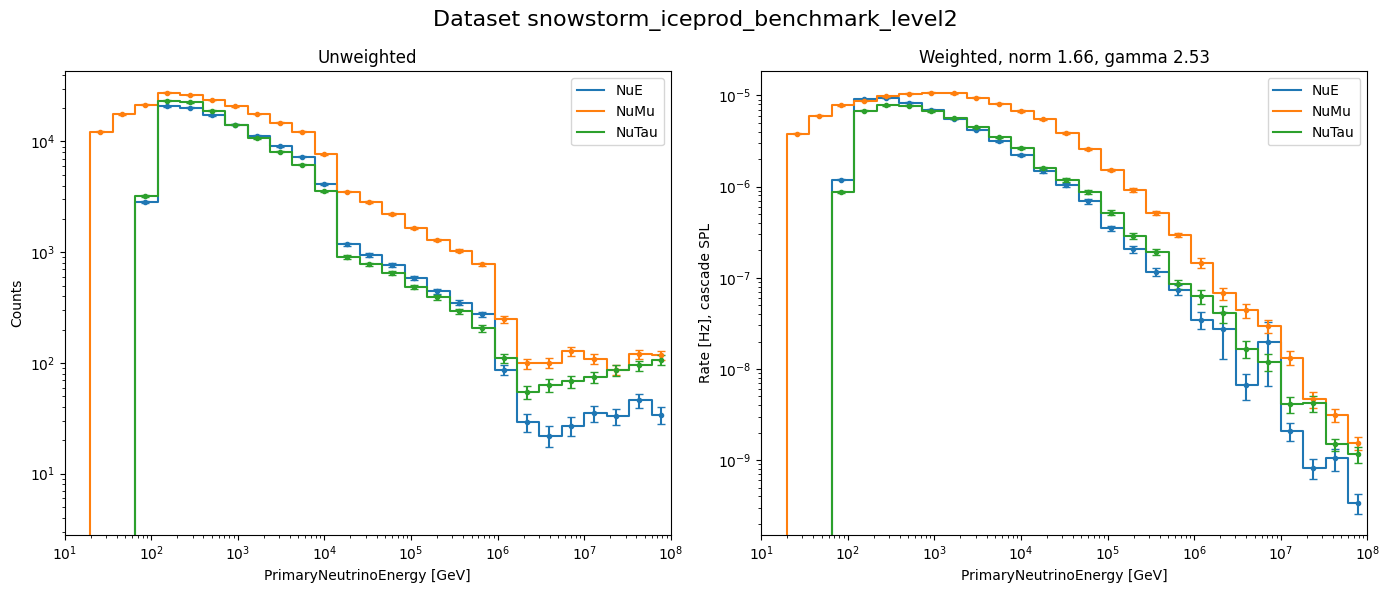

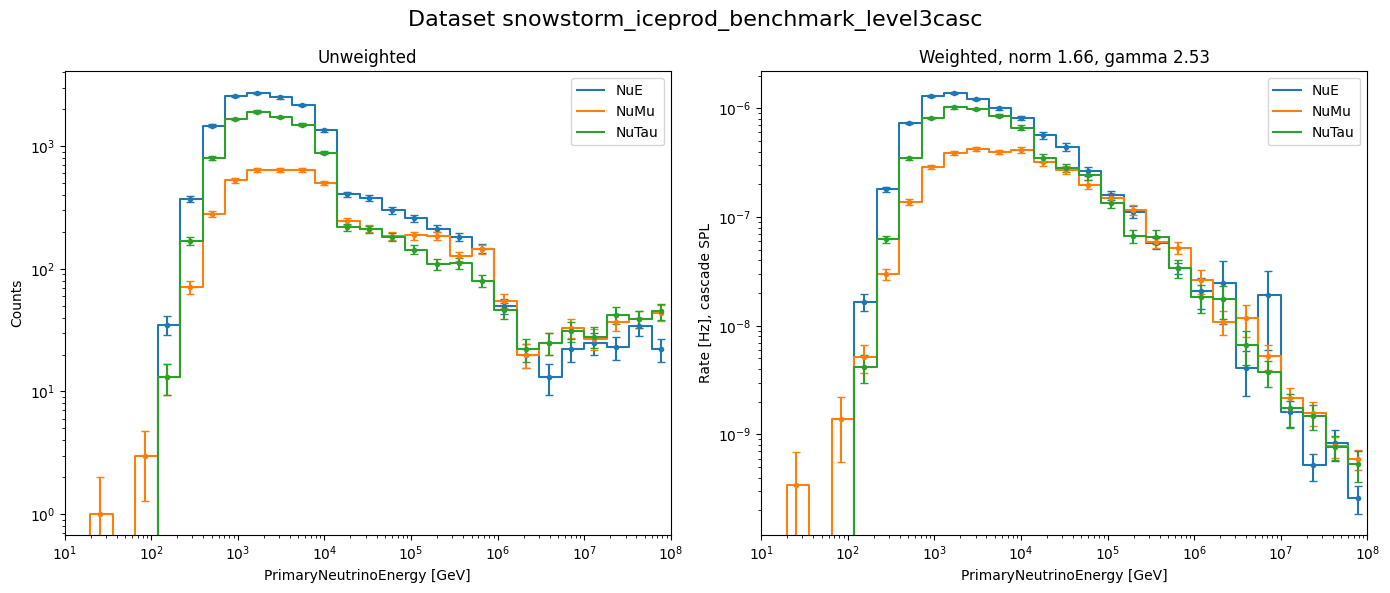

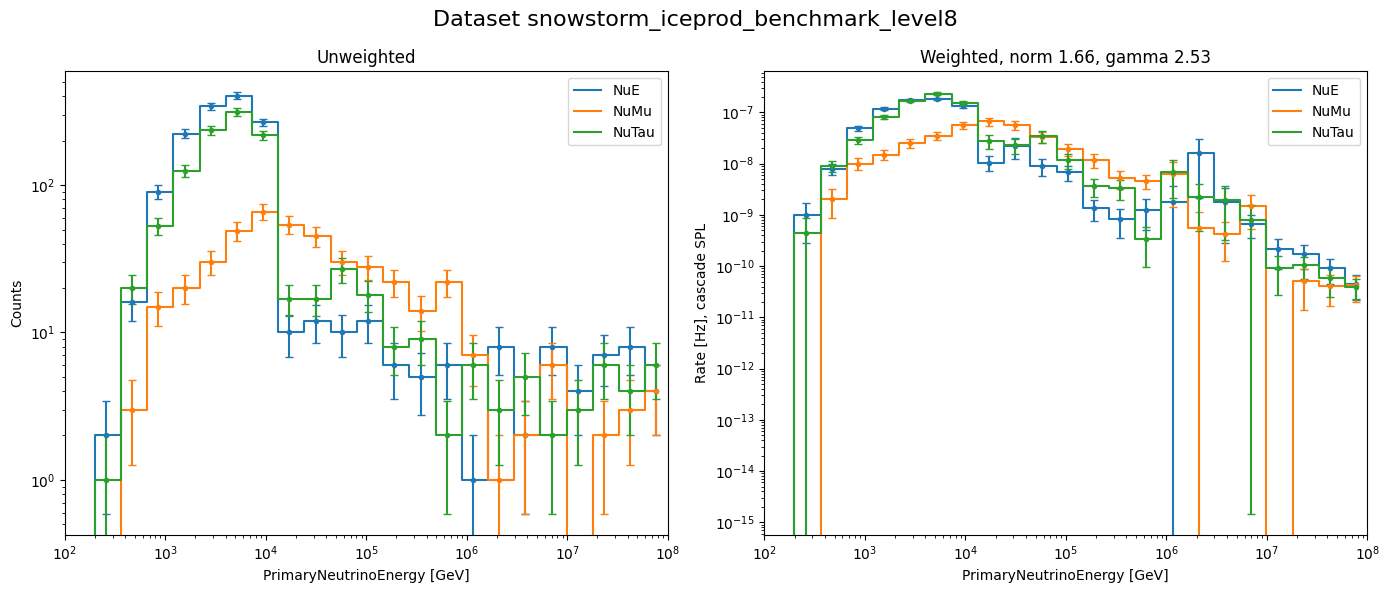

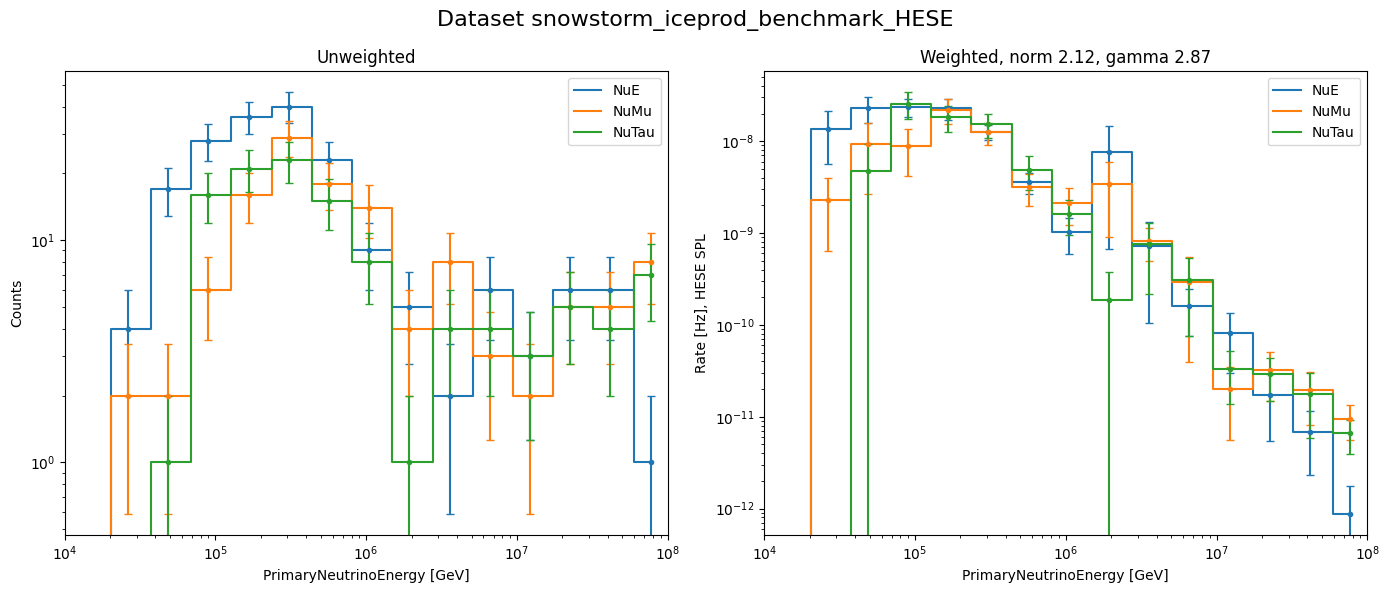

In [19]:
bins_per_decade = 4

compare_dataset_flavor( dataset_key = "snowstorm_iceprod_benchmark_level2", var_key1 = "I3MCWeightDict", var_key2 = "PrimaryNeutrinoEnergy",
                        variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e1, 1e8, 7*bins_per_decade), xscale = "log", savename="PrimaryNeutrinoEnergy_level2", fluxmodelname = "cascade" )

compare_dataset_flavor( dataset_key = "snowstorm_iceprod_benchmark_level3casc", var_key1 = "I3MCWeightDict", var_key2 = "PrimaryNeutrinoEnergy",
                        variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e1, 1e8, 7*bins_per_decade), xscale = "log", savename="PrimaryNeutrinoEnergy_level3casc", fluxmodelname = "cascade" )


compare_dataset_flavor( dataset_key = "snowstorm_iceprod_benchmark_level8", var_key1 = "I3MCWeightDict", var_key2 = "PrimaryNeutrinoEnergy",
                        variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e2, 1e8, 6*bins_per_decade), xscale = "log", savename="PrimaryNeutrinoEnergy_level8", fluxmodelname = "cascade" )

compare_dataset_flavor( dataset_key = "snowstorm_iceprod_benchmark_HESE", var_key1 = "I3MCWeightDict", var_key2 = "PrimaryNeutrinoEnergy",
                        variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 4*bins_per_decade), xscale = "log", savename="PrimaryNeutrinoEnergy_HESE", fluxmodelname = "HESE" )



